In [1]:
import numpy as np
# from geopy.distance import vincenty
from mpl_toolkits.basemap import Basemap
import h5py

import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
%matplotlib inline

from scipy.interpolate import interp1d
import pandas as pd

Center (1187, 3)
InnerPerimeter (496, 3)
Inside (7749, 3)
OuterPerimeter (465, 3)
Outside (2457, 3)


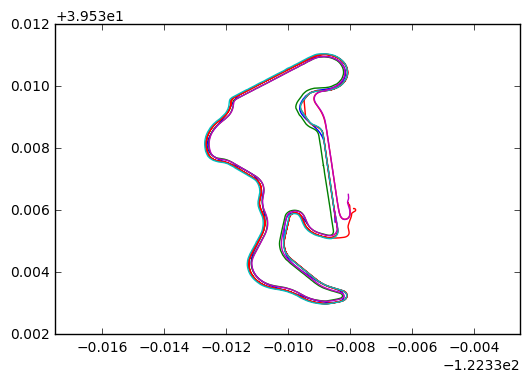

In [2]:
fileName = "Thunderhill_GPS.h5"
f = h5py.File(fileName,  "r")
Thunderhill_GPS = dict()
for item in f:
    Thunderhill_GPS[item] = f["/"+item][:]
    print(item, np.shape(Thunderhill_GPS[item]))
    plt.plot(Thunderhill_GPS[item][:,0],Thunderhill_GPS[item][:,1])

plt.axis('equal')
plt.show()

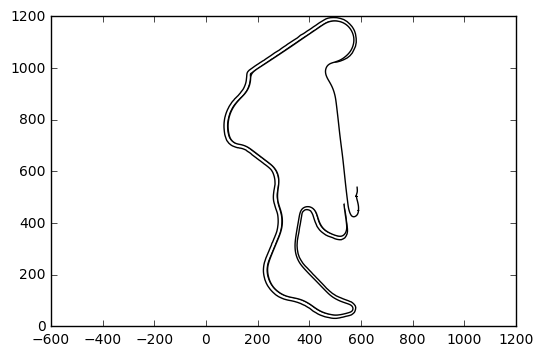

In [3]:
llcrnr = [ 39.532757, -122.343308] # Lower_left_corner_GPS
urcrnr = [ 39.541475, -122.337025] # Upper_right_corner_GPS

boundary_keys = ["OuterPerimeter","InnerPerimeter","Outside"]

fig = plt.figure()
ax = fig.add_subplot(111)
patch = []
vertices = []
path_codes = []
for k in boundary_keys:
    start = Thunderhill_GPS[k][0,:]
    m = Basemap(llcrnrlon=llcrnr[1],llcrnrlat=llcrnr[0],urcrnrlon=urcrnr[1],urcrnrlat=urcrnr[0],\
            projection='merc',lon_0=start[0],lat_0=start[1],resolution='h')
    
    verts = [m(Thunderhill_GPS[k][0,0],Thunderhill_GPS[k][0,1])]
    codes=[Path.MOVETO]
    
    for i in range(np.size(Thunderhill_GPS[k],0)):
        x1,y1=m(Thunderhill_GPS[k][i,0], Thunderhill_GPS[k][i,1])
        verts.append((x1,y1))
        codes.append(Path.LINETO)

    path = Path(verts, codes)
    patch.append(patches.PathPatch(path, facecolor='white'))
    vertices.append(verts)
    path_codes.append(codes)

# Axis limits
ll_x,ll_y = m(llcrnr[1],llcrnr[0])
ur_x,ur_y = m(urcrnr[1],urcrnr[0])

ax.set_xlim(ll_x,ur_x)
ax.set_ylim(ll_y,ur_y)

p = PatchCollection(patch,linewidths = (1,),edgecolors = ((0,0,0,1),), facecolors = 'white')

ax.add_collection(p)

# # # S/F line
# ax.set_xlim(480,520)
# ax.set_ylim(650,700)

plt.axis('equal')
plt.show()               

OuterPerimeter lap Length of Thunderhill west is  3505.9290514
InnerPerimeter lap Length of Thunderhill west is  3414.94282344
Outside lap Length of Thunderhill west is  3541.80046497


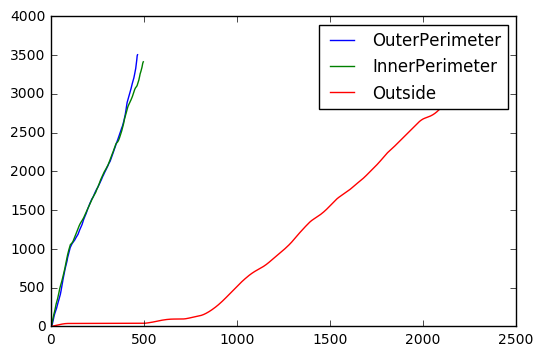

In [79]:
## Compute distance between each data point for both inner & outer perimeter
dist = []
perimeter_matrix = []
for v in vertices:
    ds = [0]
    p_mat = []
    for p in range(0,len(v)-1):
        dist_pts = np.sqrt((v[p][0]-v[p+1][0])**2 +  (v[p][1]-v[p+1][1])**2)
        ds.append(ds[-1]+dist_pts)
        p_mat.append([ds[-1],v[p][0],v[p][1]])
#     dist_pts = np.sqrt((v[-1][0]-v[0][0])**2 +  (v[-1][1]-v[0][1])**2)
#     ds.append(ds[-1]+dist_pts)
#     p_mat.append([ds[-1],v[0][0],v[0][0]])
    
    perimeter_matrix.append(np.array(p_mat))
    dist.append(ds)

for i in range(len(boundary_keys)):
    print(boundary_keys[i] + " lap Length of Thunderhill west is " ,  dist[i][-1])
    plt.plot(dist[i])
plt.legend(boundary_keys)
plt.show()

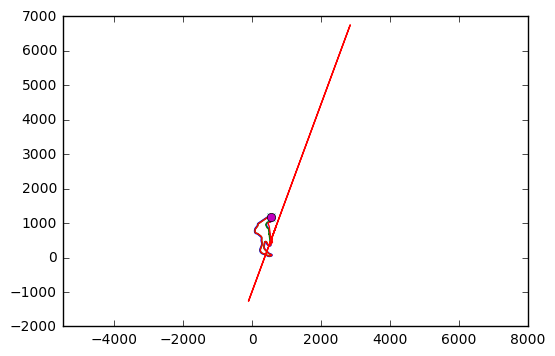

In [80]:
## In this code block, we interpolate the co-ordinates at regular distances. Since lap length is about 3500m, we create
## datapoints every 1m, so about 3500 pts.
nPts = 3500
distance_outer = np.linspace(0,dist[0][-1],nPts)
distance_inner = np.linspace(0,dist[1][-1],nPts)
distance_line = np.linspace(0,dist[2][-1],nPts)

# f_outer = pandas.DataFrame(perimeter_matrix[0][:,1:], index=perimeter_matrix[0][:,0])
# f_inner = pandas.DataFrame(perimeter_matrix[1][:,1:], index=perimeter_matrix[1][:,0])
# f_line = pandas.DataFrame(perimeter_matrix[2][:,1:], index=perimeter_matrix[2][:,0])
f_outer = interp1d(perimeter_matrix[0][:,0], perimeter_matrix[0][:,1:],axis=0, kind='cubic')
f_inner = interp1d(perimeter_matrix[1][:,0], perimeter_matrix[1][:,1:],axis=0, kind='cubic')
f_line = interp1d(perimeter_matrix[2][:,0], perimeter_matrix[2][:,1:],axis=0, kind='cubic')

inner_mat = f_inner(distance_inner)
outer_mat = f_outer(distance_outer)
line_mat = f_line(distance_line)

matrix = [outer_mat, inner_mat, line_mat]

fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(len(matrix)):
    plt.plot(matrix[i][:,0],matrix[i][:,1])

ax.set_xlim(ll_x,ur_x)
ax.set_ylim(ll_y,ur_y)

ind = 650
plt.plot(matrix[0][ind,0],matrix[0][ind,1],'x')
plt.plot(matrix[1][ind,0],matrix[1][ind,1],'o')

plt.axis('equal')
plt.show()

## In the plot below, the circle represents a point on the inner perimeter
## The cross points to an point on the outer perimeter.
## Note how these two points are perpendicular to the tangent to the track at that point.

In [156]:
## Now that all points are (almost) equi-distant, we can compute the centerline as the average co-ordinate
## of the corresponding inner and outer co-ordinates.
print(matrix[0][:3,0],matrix[1][:3,0])
centerline = np.vstack(((matrix[0][:,0]+matrix[1][:,0])/2.0,(matrix[0][:,1]+matrix[1][:,1])/2.0)).T
print(np.shape(centerline))

[ 509.60709526  509.66140842  509.66689654] [ 494.94438885  495.0261468   495.07965683]
(3500, 2)


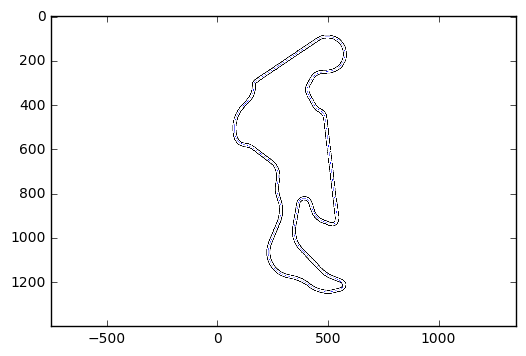

In [157]:
import cv2
img = np.zeros((1400,600, 3), np.uint8)
img[:,:,0] = 255*np.ones((1400,600))
img[:,:,1] = 255*np.ones((1400,600))
img[:,:,2] = 255*np.ones((1400,600))

offset_plotting = 100

avg_yc = np.mean(centerline[:,1])

for i in range(1,nPts):
#     cv2.line(img,(int(matrix[0][i-1,0]),int(matrix[0][i-1,1])),(511,511),(255,0,0),5)
    cv2.line(img,(int(matrix[0][i-1,0]),int(2*avg_yc-matrix[0][i-1,1])+offset_plotting),\
             (int(matrix[0][i,0]),int(2*avg_yc-matrix[0][i,1])+offset_plotting), color=(1,1,1,), thickness=2)
    cv2.line(img,(int(matrix[1][i-1,0]),int(2*avg_yc-matrix[1][i-1,1])+offset_plotting),\
             (int(matrix[1][i,0]),int(2*avg_yc-matrix[1][i,1])+offset_plotting), color=(1,1,1,), thickness=2)
    cv2.line(img,(int(centerline[i-1,0]),int(2*avg_yc-centerline[i-1,1])+offset_plotting),\
             (int(centerline[i,0]),int(2*avg_yc-centerline[i,1])+offset_plotting), color=(1,1,255,), thickness=1)
#     cv2.circle(img,(int(matrix[2][i-1,0]),int(2*avg_yc-matrix[2][i-1,1])), 1, (0,0,255))

plt.axis('equal')

# # S/F line
# ax.set_xlim(480,520)
# ax.set_ylim(650,700)

 # Crop from x, y, w, h -> 100, 200, 300, 400
# NOTE: its img[y: y + h, x: x + w] and *not* img[x: x + w, y: y + h]
# cv2.imshow('cropped',crop_img)


plt.imshow(img)

In [158]:
import imageio
imageio.plugins.ffmpeg.download()
import numpy as np
import moviepy.editor as mpy
import cv2
W = 1
fps = 24
maxp = np.size(matrix[2],0)
## Reflect matrix, so that track gets displayed correctly on the image.


def make_frame(t):
    pi = int(t * fps) % maxp
    p = (matrix[2][pi,0],matrix[2][pi,1])
    if pi > 0:
        p_prev = (int(matrix[2][pi-fps,0]),int(2*avg_yc-matrix[2][pi-fps,1]+offset_plotting))
        for i in range(fps):
            p1 = (int(matrix[2][pi-fps+i,0]),int(2*avg_yc-matrix[2][pi-fps+i,1]+offset_plotting))
            cv2.line(img,p_prev,p1, color=(255,1,1,), thickness=1)
            p_prev = p1
            
    current_pos = (int(p[0]), int(2*avg_yc-p[1])+offset_plotting)
    
    cp_img = np.copy(img)
    cv2.circle(cp_img,(current_pos[0], current_pos[1]), pi % 10, (255,0,0),3)
#     crop_img = cp_img[current_pos[0]-10:current_pos[0]+10,current_pos[1]-10:current_pos[1]+10,:];
    return cp_img # returns a 8-bit RGB array

# clip = mpy.VideoClip(make_frame, duration=(int(maxp/fps)+1)) # 2 seconds
# clip.write_videofile("path.mp4",fps=fps, codec='mpeg4')

[96.878019601325661, 96.878019601325661, -84.216458313659558, -84.035182404248872, 93.745844224671217, 95.48904256701654, 95.630220554244346, 95.706075133211272, 95.77220269809348, 95.84555769683125]
[96.878019601325661, 96.878019601325661, 95.48904256701654, 95.630220554244346, 95.706075133211272, 95.77220269809348, 95.84555769683125, 95.915639220659187, 95.960102525284825, 95.977312189032943]


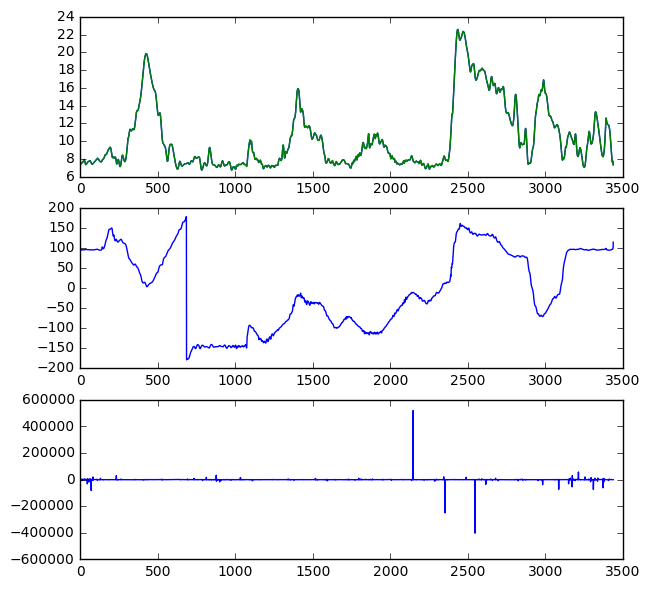

In [159]:
# print(matrix[0][:3,:])
# print(matrix[1][:3,:])
# print(centerline[:3,:])

x_diff = np.diff(centerline[:,0])
y_diff = np.diff(centerline[:,1])
distance_delta = np.sqrt(np.power(x_diff,2)+np.power(y_diff,2))
final_distance_delta = np.sqrt(np.power(centerline[0,0]-centerline[-1,0],2)+\
                               np.power(centerline[0,1]-centerline[-1,1],2))
distance = [0]
inner_width = []
outer_width = []
track_heading = [np.degrees(np.arctan2(centerline[0,1]-centerline[-1,1],centerline[0,0]-centerline[-1,0]))]
track_curvature = []
for i in range(len(distance_delta)):
    distance.append(distance[-1]+distance_delta[i])
    inner_width.append(np.sqrt(np.power(centerline[i,0]-inner_mat[i,0],2)+np.power(centerline[i,1]-inner_mat[i,1],2)))
    outer_width.append(np.sqrt(np.power(centerline[i,0]-outer_mat[i,0],2)+np.power(centerline[i,1]-outer_mat[i,1],2)))
    track_heading.append(np.degrees(np.arctan2(centerline[i,1]-centerline[i-1,1],centerline[i,0]-centerline[i-1,0])))
    track_curvature.append(np.arctan(np.tan(np.radians(track_heading[i] - track_heading[i-1])))/distance_delta[i])

track_curvature.append(np.arctan(np.tan(np.radians(track_heading[0] - track_heading[-1])))/final_distance_delta)
inner_width.append(np.sqrt(np.power(centerline[-1,0]-inner_mat[-1,0],2)+np.power(centerline[-1,1]-inner_mat[-1,1],2)))
outer_width.append(np.sqrt(np.power(centerline[-1,0]-outer_mat[-1,0],2)+np.power(centerline[-1,1]-outer_mat[-1,1],2)))

nPlots = 3
f, axarr = plt.subplots(nPlots,1,figsize=(7, 7))

# Remove first three points
centerline = centerline[3:,:]
inner_width = inner_width[3:]
outer_width = outer_width[3:]
print(track_heading[0:10])
track_heading = [track_heading[0], track_heading[1]] + track_heading[5:]
print(track_heading[0:10])
track_curvature = track_curvature[3:]
distance = distance[3:]
# print(track_curvature)

axarr[0].plot(distance,inner_width)
axarr[0].plot(distance,outer_width)
# axarr[0].title('Track Width')

axarr[1].plot(distance,track_heading)
# axarr[1].title('Track Heading Angle')

axarr[2].plot(distance,1/np.array(track_curvature))
# axarr[1].title('Track Curvature')

In [160]:
dist = np.array(distance).reshape(len(distance),1) - dist[0]
heading = np.array(track_heading).reshape(len(distance),1)
curvature = np.array(track_curvature).reshape(len(distance),1)

track = np.hstack((centerline,heading))
track = np.hstack((track,curvature))
print(heading)
f_track = interp1d(distance,track,axis=0)

def ComputeDistance(p1,p2):
    return np.sqrt(np.power(p1[0]-p2[0],2)+np.power(p1[1]-p2[1],2))

def GetStates(alpha,states):
    Vx1 = V*np.cos(np.radians(alpha))
    Vy1 = V*np.sin(np.radians(alpha))
    
    pos_x = states[0] + (Vx1)*dt#-states[2])*dt
    pos_y = states[1] + (Vy1)*dt#-states[3])*dt
    
    return [pos_x,pos_y,Vx1,Vy1]

def steering_controller():
    pass


[[  96.8780196 ]
 [  96.8780196 ]
 [  95.48904257]
 ..., 
 [ 101.92127316]
 [ 105.08130604]
 [ 115.39641641]]


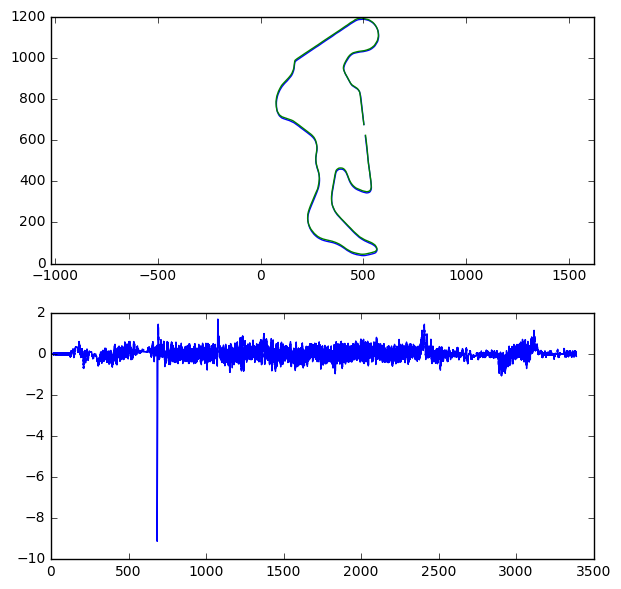

In [353]:
V = 20 # constant speed in m/s
dt = 0.01 # Time step for integration
wheel_base = 2.5 # wheel base in meters

pvw_dist = 10.0
num_pvws = 10
pvw_weights = [1/(i+1) for i in range(num_pvws)]

max_steer = 25 # degrees
steer_bnds = [max_steer/(num_pvws-i) for i in range(num_pvws)]
K_phi = 0.1
steer_gain = list(np.array([10,10,6,2,0.8,0.16,0.04,0.01,0.01,0.01])/15)
# steer_gain = np.array([10,4,2,2,0.8,0.16,0.04,0.01,0.01,0.01])/10.0
# steer_gain =list(steer_gain)#/sum(steer_gain))
start_pt = 0

s = [distance[start_pt]]

x0 = centerline[start_pt,0]
y0 = centerline[start_pt,1]

xv = [x0]
yv = [y0]

xt = [x0]
yt = [y0]

Vx = [V]
Vy = [0]
beta = [track_heading[start_pt]]
phi_v = [track_heading[start_pt]]
phi_t = [track[start_pt,2]]

steer = [0]

iteration = 0
n_iters = 100
cond = True
pix = []
piy = []
clineposx = []
clineposy = []
iters = 0
trk_s = f_track(s[-1])
lat_deviation = [0]
while iters < 17000:#s[-1] < distance[-1]/5-pvw_dist:    
    CTE = (yv[-1]-yt[-1])*np.cos(np.radians(phi_t[-1])) - (xv[-1]-xt[-1])*np.sin(np.radians(phi_t[-1]))
    lat_deviation.append(CTE)
    pvw_lat_deviation = list()
    str_angle = 0
    for i in range(num_pvws):
        pvw_trk_s = f_track(s[-1]+float(i)*pvw_dist/num_pvws)
        dev_i = (yv[-1] - pvw_trk_s[1])*np.cos(np.degrees(phi_v[-1])) \
            - (xv[-1] - pvw_trk_s[0])*np.sin(np.degrees(phi_v[-1]))
        pvw_lat_deviation.append(dev_i)
        str_angle = str_angle + min(steer_bnds[i],max(-steer_bnds[i],dev_i*steer_gain[i]))

    yaw_err = min(max_steer/2,max(-max_steer/2,K_phi*(phi_t[-1] - phi_v[-1])))
    curr_steer = yaw_err + 0.1*str_angle
    u_st = 1*curr_steer# + 0.01*(curr_steer - steer[-1])*dt
    steer.append(u_st)#min(max_steer,max(-max_steer,yaw_err + str_angle)))
    if len(steer) > 5:#1/dt:
        steer[-1] = np.mean(steer[-5:])
    else:
        steer[-1] = np.mean(steer)
        
    beta.append(beta[-1]+steer[-1])
#     beta.append(beta[-1] + np.degrees(np.arctan(0.5*(np.tan(np.radians(steer[-1]))))))

    phi_v.append(phi_v[-1] + steer[-1])#V*dt*np.cos(np.radians(beta[-1]))/wheel_base*np.tan(np.radians(steer[-1])))#
    Vx = V*np.cos(np.radians(beta[-1]))
    Vy = V*np.sin(np.radians(beta[-1]))
    xv.append(xv[-1] + Vx*dt)
    yv.append(yv[-1] + Vy*dt) 

    dsv = V*dt
    ds1 = dsv*np.cos(np.radians(beta[-1]-phi_t[-1]))
    ds = ds1#/(1-(CTE*np.abs(trk_s[3])))
    s.append(s[-1]+ds)
    trk_s = f_track(s[-1])
    phi_t.append(trk_s[2])
    xt.append(trk_s[0])
    yt.append(trk_s[1]) 
    iters = iters + 1
    
nPlots = 2
f, axarr = plt.subplots(nPlots,1,figsize=(7, 7))

# axarr[0].plot(centerline[start_pt:start_pt+400,0],centerline[start_pt:start_pt+400,1])
axarr[0].plot(xt,yt)
axarr[0].plot(xv,yv)#,'+-')#,'+')

axarr[0].axis('equal')
# axarr[0].axis('square')

# axarr[1].plot(s)
# axarr[1].plot(beta)
# axarr[1].plot(phi_v)
# axarr[2].plot(s,phi_v)
# axarr[2].plot(s,phi_t)
axarr[1].plot(s,steer)    

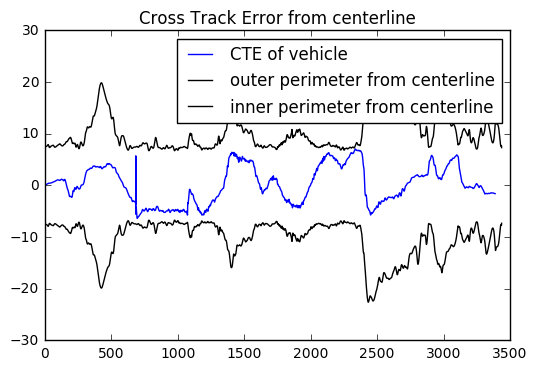

In [357]:
plt.plot(s,lat_deviation)
plt.plot(distance,inner_width,'k')
plt.plot(distance,-np.array(outer_width),'k')
plt.legend(['CTE of vehicle', "outer perimeter from centerline", "inner perimeter from centerline" ])
plt.title("Cross Track Error from centerline")